## Monte Carlo simulation trial

In [1]:
%matplotlib inline
from __future__ import print_function,absolute_import,division,unicode_literals
import numpy as np
import glob,os,sys,copy,imp 
from scipy import stats as scistats
import matplotlib as mpl
mpl.rcParams['font.family']='stixgeneral'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import QTable,Table
from astropy.io import ascii,fits
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from linetools.spectralline import AbsLine
import linetools.utils as ltu
from xastropy.igm.abs_sys import abssys_utils as abssys
from xastropy import spec as xpsec
from xastropy.plotting import utils as xputils
from xastropy.xutils import xdebug as xdb
from xastropy.obs import radec as xor
from xastropy.atomic import ionization as xai
from xastropy.xutils import fits as xxf
sys.path.append(os.path.abspath("../../../py"))
from enigma.qpq import utils as qpqutils
from enigma.qpq import spec as qpqs
from enigma.qpq import stacks as qpqk
sys.path.append(os.path.abspath("./Stacks/py"))
import qpq9_stacks as qpq9k
import scipy.integrate as integrate
from astropy.modeling import models,fitting
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70,Om0=0.26)

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [11]:
def gen_stck_img(R_phys,z_fg,Deltav,v_grid,n_trials): # R_phys in kpc, Deltav in km/s
    probs = np.zeros(len(v_grid))
    cumulative_probs = np.zeros(len(v_grid))
    Hubble_h = cosmo.H(0).value/100.
    ell_IGM_DLA = 0.2*((1+z_fg)/(1+2.5))**2.1
    ell_IGM_SLLS = 0.44*((1+z_fg)/(1+2.5))**2.1
    ell_IGM_LLS = 1.05*((1+z_fg)/(1+2.5))**2.1
    R_comov = R_phys/1000.*(1+z_fg)*Hubble_h # in h^-1 Mpc 
    for ii,vv in enumerate(v_grid):
        gamma_DLA = 1.6
        r0_DLA = 3.9
#        gamma_SLLS = 1.6
#        r0_SLLS = 15.5
#        gamma_LLS = 1.6
#        r0_LLS = 13.9
        gamma_SLLS = 1.68
        r0_SLLS = 14.0
        gamma_LLS = 1.68
        r0_LLS = 12.5
        chi_DLA = 1./Deltav*integrate.quad(
            lambda v:(np.sqrt(R_comov**2+(v/(cosmo.H(z_fg).value/(1+z_fg)))**2)/r0_DLA)**(-gamma_DLA),
            v_grid[ii]-Deltav/2,v_grid[ii]+Deltav/2)[0]
        chi_SLLS = 1./Deltav*integrate.quad(
            lambda v:(np.sqrt(R_comov**2+(v/(cosmo.H(z_fg).value/(1+z_fg)))**2)/r0_SLLS)**(-gamma_SLLS),
            v_grid[ii]-Deltav/2,v_grid[ii]+Deltav/2)[0]
        chi_LLS = 1./Deltav*integrate.quad(
            lambda v:(np.sqrt(R_comov**2+(v/(cosmo.H(z_fg).value/(1+z_fg)))**2)/r0_LLS)**(-gamma_LLS),
            v_grid[ii]-Deltav/2,v_grid[ii]+Deltav/2)[0]
        Deltaz = ltu.z_from_v(z_fg,v_grid[ii]+Deltav/2)-ltu.z_from_v(z_fg,v_grid[ii]-Deltav/2)
        prob = (ell_IGM_DLA*(1+chi_DLA)+ell_IGM_SLLS*(1+chi_SLLS)+ell_IGM_LLS*(1+chi_LLS))*Deltaz
        # test effect of doubling number of absorbers 
#        prob = prob*2
        probs[ii] = prob
        cumulative_probs[ii] = prob + np.sum(probs[0:ii])
    norm = np.sum(probs)
    probs = probs/norm
    print('Expected number of absorbers at R_phys',norm,R_phys)   
    stck_img = np.zeros((n_trials,len(v_grid)))
    for nt in np.arange(n_trials):
        N_abs = np.random.poisson(norm)
        flux = np.ones(len(v_grid))
        for ii,na in enumerate(np.arange(N_abs)):
            v_Hubble = np.random.choice(v_grid,p=probs)
            v_peculiar = np.random.normal(loc=0.,scale=212.) # sigma_1D for QPQ halo mass 
            # Want mean = 207 km/s, final dispersion = 352 km/s
#            v_peculiar = np.random.normal(loc=170.,scale=283.)
            v_add = v_Hubble + v_peculiar
        # rest EW = 0.3 angstrom, mean of QPQ8
#            one_abs = models.GaussianAbsorption1D(amplitude=0.74,mean=v_add,stddev=35.)
            # Higher rest EW to match data amplitude 
            one_abs = models.GaussianAbsorption1D(amplitude=3.0,mean=v_add,stddev=39.) 
            flux = flux*one_abs(v_grid)
            flux[np.where(flux < 0.)] = 0.
        stck_img[nt,:] = flux    
    
    return stck_img

rest EW in angstrom 0.695065490583


/Users/lwymarie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


[-200, 200, 0, 1.05]

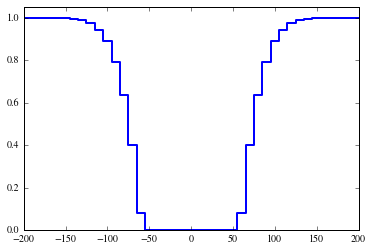

In [12]:
# Try CII absorbers of other amplitude, std_dev that preserve rest EW = 0.31 angstrom 
Deltav = 10.
v_grid = -2000. + np.arange((2000.-(-2000.))/Deltav+1)*Deltav
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
wave_grid = (v_grid*u.km/u.s).to(u.AA,equivalencies=relativistic_equiv)
#tau = models.Voigt1D(x_0=0.,amplitude_L=244,fwhm_L=0.7,fwhm_G=35)
#tau2 = models.Voigt1D(x_0=100.,amplitude_L=244,fwhm_L=0.7,fwhm_G=35)
#flux = np.exp(-1.*tau(v_grid))*np.exp(-1.*tau2(v_grid))
one_abs = models.GaussianAbsorption1D(amplitude=3.0,mean=0,stddev=39.)
flux = one_abs(v_grid)
flux[np.where(flux < 0.)] = 0.
tau = -np.log(flux)
total_flux = np.exp(-tau)
plt.plot(v_grid,total_flux,drawstyle='steps-mid',linewidth=2)
print('rest EW in angstrom',np.sum((1.-total_flux[:-1])*np.diff(wave_grid.value)))
plt.axis([-200,200,0,1.05])
#one_abs = models.GaussianAbsorption1D(amplitude=0.7,mean=0,stddev=39.)
#flux = one_abs(v_grid)
#tau = -np.log(flux)
#total_flux = np.exp(-2*tau)
#plt.plot(v_grid,total_flux,drawstyle='steps-mid',linewidth=2)
#print('rest EW in angstrom',np.sum((1.-total_flux[:-1])*np.diff(wave_grid.value)))

In [4]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,
                               vsig_cut=400*u.km/u.s,zfg_mnx=(1.6,9999),plot_indiv=False)
fin_velo, stck_img, stck_msk, all_dict = stack_tup0

/Users/lwymarie/python/specdb/specdb/query_catalog.py:140: UserWarning: No sources found at your coordinate within tol=0.5 arcsec.  Returning None
  warnings.warn("No sources found at your coordinate within tol={:g}.  Returning None".format(tol))
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:295: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
4.50292750736 1 / Angstrom
No spectrum found for BOSSJ0008-0039 and wvobs=3921.71 Angstrom!
3.96738337038 1 / Angstrom
No spectrum found for BOSSJ0042+1350 and wvobs=3705.49 Angstrom!
81.2002163512 1 / Angstrom
43.8725850917 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ034139.19-000012.7_b1200_F.fits.gz for SDSSJ0341-0000
S/N 81.2002163512 1 / Angstrom
91.8637821431 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ080048.74+354231.3_b1200_F.fits.gz for APOJ0800+3542
S/N 91.8637821431 1 / Angstrom
6.81812554325 1 / Angstrom
Using spec-7328-56715-0428.fits.gz for BOSSJ0809+4539
S/N 6.81812554325 1 / Angstrom
No spectrum found for BOSSJ0826+4708 and wvobs=3735.68 Angstrom!
7.18837682491 1 / Angstrom
30.3853921563 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ082844.87+454518.2_b1200_F.fits.gz for SDSSJ0828+4545
S/N 30.3853921563 1 / Angstrom
30.232

/Users/lwymarie/python/specdb/specdb/query_catalog.py:145: UserWarning: Found multiple sources in the catalog. Taking the closest one
  warnings.warn("Found multiple sources in the catalog. Taking the closest one")
/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:850: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__itruediv__(other)



143.701568431 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ114436.66+095904.9_F.fits.gz for BOSSJ1144+0959
S/N 143.701568431 1 / Angstrom
No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ120416.69+022111.0_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz
Using conti=1 for HIRES
143.009676121 1 / Angstrom
47.1880601379 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz for BOSSJ1204+0221
S/N 143.009676121 1 / Angstrom
15.4009220707 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ121558.80+571555.4.fits.gz for BOSSJ1215+5715
S/N 15.4009220707 1 / Angstrom
77.9062475252 1 / Angstrom
12.5394715796 1 / Angstrom
30.426493273 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ123141.73+002913.9_b600_F.fits.gz for BOSSJ1231+0029
S/N 77.9062475252 1 / Angstrom
5.7442684952 1 / Angstrom
Using spec-6482-563

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:850: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__itruediv__(other)
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:807: UserWarning: Ignoring NAN and inf in flux
  warnings.warn("Ignoring NAN and inf in flux")


In [13]:
n_trials = 1000
Deltav = 10.
v_grid = -2000. + np.arange((2000.-(-2000.))/Deltav+1)*Deltav
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
wave_grid = (v_grid*u.km/u.s).to(u.AA,equivalencies=relativistic_equiv)
sv_mean_flux = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']:
        continue
    else:
        stck_img = gen_stck_img(idict['qpq']['R_PHYS'],idict['qpq']['Z_FG'],Deltav,v_grid,n_trials)
        mean_flux = np.sum(stck_img,0)/n_trials
        sv_mean_flux.append(mean_flux)

Expected number of absorbers at R_phys 0.494885927034 190.162078857
Expected number of absorbers at R_phys 0.420010063781 200.727334478
Expected number of absorbers at R_phys 0.352109337509 291.955898238
Expected number of absorbers at R_phys 0.480918638057 137.483764648
Expected number of absorbers at R_phys 0.7578484166 89.2255343659
Expected number of absorbers at R_phys 0.470437269789 182.693675263
Expected number of absorbers at R_phys 0.880217640627 111.641532541
Expected number of absorbers at R_phys 1.3434117378 88.838035754
Expected number of absorbers at R_phys 0.376200731473 235.999657906
Expected number of absorbers at R_phys 0.574920592369 106.124389648
Expected number of absorbers at R_phys 0.553144419628 237.906701175
Expected number of absorbers at R_phys 0.347666283058 211.233413696
Expected number of absorbers at R_phys 0.503911036268 127.239715576
Expected number of absorbers at R_phys 0.355574057895 271.170697934
Expected number of absorbers at R_phys 0.959100226593

Rest EW in angstrom: 0.431786374476


<CompoundModel3(amplitude_0=0.9960381388738743, amplitude_1=0.13312586465702933, mean_1=-3.265905340681202, stddev_1=244.08599532050962)>

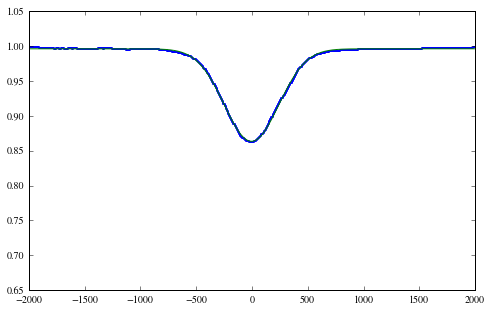

In [15]:
mean_flux = np.mean(sv_mean_flux,0)
plt.figure(figsize=(8,5))
plt.plot(v_grid,mean_flux,drawstyle='steps-mid',linewidth=2.,)
plt.axis([-2000,2000,0.65,1.05])
print('Rest EW in angstrom:',np.sum((1.-mean_flux[:-1])*np.diff(wave_grid.value)))
model_init = models.GaussianAbsorption1D(amplitude=0.11,mean=0.,stddev=250.)
c_init = models.Const1D(amplitude=0.997)
model_init = c_init*model_init
fit = fitting.LevMarLSQFitter()
model_final = fit(model_init,v_grid,mean_flux)
plt.plot(v_grid,model_final(v_grid))
model_final
#tau = np.log(1./(mean_flux))
#tau_disp = np.sqrt(np.sum(v_grid**2*tau)/np.sum(tau))
#print(tau_disp)
#print(np.sum((v_grid**2)*np.log(1/(mean_flux/0.994))))

In [16]:
# save model 
dict = {}
for ii,pp in enumerate(model_final.parameters):
    dict[model_final.param_names[ii]] = [pp]
ascii.write(Table(dict),'monte.dat')

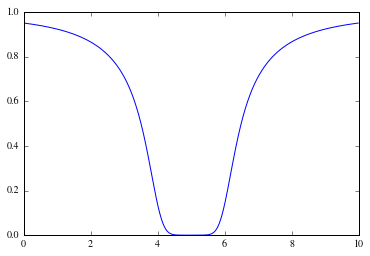

In [7]:
from astropy.modeling.models import Voigt1D
plt.figure()
x = np.arange(0, 10, 0.01)
v1 = Voigt1D(x_0=5, amplitude_L=20, fwhm_L=0.5, fwhm_G=0.9)
plt.plot(x, np.exp(-1.*v1(x)))
plt.show()

In [8]:
# Find mean equivalent width of QPQ8 LLS
np.mean([0.000,0.042,0.345,0.195,0.025,0.030,0.053,0.168,0.504,0.248,0.779,0.281,0.341,
         0.328,0.756,0.650,0.154,0.179,0.130,0.950])

0.30790000000000001